
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Using Dask to Scale Up Your Data Analaysis
**ESDS 2024 Annual Event Xarray-Dask Tutorial | January 19th, 2023**  

Negin Sobhani and Brian Vanderwende  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

------

### In this tutorial, you learn:

* Intro to Dask
* Dask distributed - clusters & clients (30 mins)
* Optimizing and debugging Dask (20 mins)


### Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Basic familiarity with NumPy	 | Necessary | |
| Basic familiarity with Pandas	 | Necessary | |
| Familiarity with Xarray        | Necessary | |

- **Time to learn**: 60 minutes

---------

## Introduction to Dask

<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/dask_horizontal.svg"
     width="500px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

* Dask is an open-source Python library for parallel and distributed computing that scales the existing Python ecosystem.

* Dask was developed to scale Python packages such as Numpy, Pandas, and Xarray to multi-core machines and distributed clusters when datasets exceed memory.


## Why Dask?

### Familiar Interface 

Dask provides interfaces which mimics significant portions of the NumPy and Pandas APIs. 

This means Dask provides ways to parallelize Pandas, Xarray, and Numpy workflows with minimal code rewriting (no massive code-restructure or writing a script in another language). In the previous tutorial, we learned how Xarray can wrap other NumPy-like arrays. 

### Scalability
Dask is designed to scale well from single machine (laptop) to thousand-node HPC clusters, and on the cloud.

This allows users to use their existing hardware, or add more machines as needed, to handle increasingly large and complex datasets.

### Flexibility
Dask provides several tools that help with data analysis on large datasets. For example, you can easily wrap your function in `dask.delayed` decorator to make it run in parallel. 

Dask provides seamless integration with well-known HPC resource managers and job scheduling systems, including PBS, SLURM, and SGE.

### Built-in Diagnostic Tools
Dask provides responsive feedback via the client as well as a real-time interactive diagnostic dashboard to keep users informed on how the computation is progressing.  

This helps users identify and resolve potential issues without waiting for the work to be completed. 

## When to use Dask?
Here are some general guidelines for when to use Dask and when to avoid it:

#### Use Dask:
* When you have large datasets that don't fit into memory on a single machine.
* When you need to perform parallel computations, such as big data analysis. 

#### Avoid Dask:

* When you have small datasets that can be processed efficiently on a single machine.
* When you don't need parallel processing, as the overhead of managing a distributed computing environment may not be worth the benefits.
* When you need to debug or troubleshoot problems, as distributed computing environments can be challenging for debugging. If the problem is complex, using Dask may make debugging more difficult.

## Dask Components

Dask is composed of two main parts:

### 1.  Dask Collections

Dask *Collections* are the user interfaces we use for parallel and distributed computing with Dask.

Dask features different levels of collection types:

#### High-level collections 
Dask provides high-level collections Dask Arrays, Dask DataFrames, and Dask Bags that mimic NumPy, pandas, and lists but can operate in parallel on datasets that don’t fit into memory.

Most of the time, you will probably use one of the following *high-level* (big) data structures (or an even higher-level derivative type like Xarrays):

| Collection | Serial | Dask |
|-|-|-|
| Arrays | numpy.array | dask.array.from_array |
| Dataframes | pandas.read_csv | dask.dataframe.read_csv |
| Unstructured | [1,2,3] | dask.bag.from_sequence([1,2,3]) |


#### Low-level collections
Dask also features two *low-level* collection types - `delayed` and `futures`.  These collections give users finer control to build custom parallel and distributed computations.

* **delayed** - run any arbitrary Python function using Dask task parallelism (think looped function calls)
* **futures** - similar to delayed but allows for concurrent commands in the client script (think backgrounded processes)

These are very powerfull tools, but it is easy to write something using a delayed function that could be executed faster and more simply using a high-level collection 

<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/high_vs_low_level_coll_analogy.png"
     width="83%"
     alt="Dask Collections"/>
     
*Image credit: Anaconda, Inc. and contributors*


### 2. Dynamic Task Scheduling
**We can basically think of the Dask scheduler as our task orchestrator.**

When a computation is submitted, work is segmented into discrete tasks which are assigned to workers by the Dask scheduler. 

To perform work, a scheduler must be assigned resources in the form of a Dask cluster. The cluster consists of the following components: 

* **scheduler** : A scheduler creates and manages task graphs and distributes tasks to workers.

* **workers** : A worker is typically a separate Python process on either the local host or a remote machine. A Dask cluster usually consists of many workers. Basically, a worker is a Python interpretor which will perform work on a subset of our dataset.

* **client** - A high-level interface that points to the scheduler (often local but not always). A client serves as the entry point for interacting with a Dask scheduler.

<img src="https://tutorial.dask.org/_images/distributed-overview.png"
     width="75%"
     alt="Dask Distributed Cluster"/>
     
*Image credit: Anaconda, Inc. and contributors*


We will learn more about Dask Collections and Dynamic Task Scheduling in the next tutorials.

## Deploying Dask Cluster
There are many different implementations of the Dask distributed cluster.

`dask-jobqueue`: Deploy Dask on job queuing systems like PBS, Slurm, MOAB, SGE, LSF, and HTCondor.

`dask-kubernetes`: Deploy Dask workers on Kubernetes from within a Python script or interactive session.

`dask-helm`: Deploy Dask and (optionally) Jupyter or JupyterHub on Kubernetes easily using Helm.

`dask-cloudprovider`: Deploy Dask on various cloud platforms such as AWS, Azure, and GCP leveraging cloud native APIs.

`dask-gateway`: Secure, multi-tenant server for managing Dask clusters. Launch and use Dask clusters in a shared, centrally managed cluster environment, without requiring users to have direct access to the underlying cluster backend.

## Starting HPC Dask clusters with `dask-jobqueue`

A defining feature of most HPC systems is the batch scheduler - *Slurm, PBS, LSF, etc...* These schedulers allow us to access the significant resources of the system and scale far beyond what is capable by a personal workstation.

Using Dask on an HPC system is no different - we need to interact with the scheduler to provide Dask with ample compute resources. We *could* first start a job with multiple cores and a large amount of memory, and then use the **LocalCluster** to spawn workers. However, this approach only scales to a single node.

The typical approach is to let Dask request resources directly from the job scheduler via a scheduler-specific cluster type. Such clusters are provided by the add-on `dask-jobqueue` package.

### Creating a scheduled-cluster

Since we use the PBS Pro scheduler at NCAR, we will use the **PBSCluster** Dask scheduler from `dask-jobqueue`. Initialization is similar to a **LocalCluster**, but with unique parameters specific to creating batch jobs.

In [5]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

The parameters of the `PBSCluster` provide a basic template for the resources that will be assigned to each job...

In [6]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '30:00',
)

*Since we are working on a shared system, you may get a port-in-use warning. This is no cause for alarm, but make sure you are not starting a duplicate cluster unintentionally.*

We should pause and consider some of these settings...

* The `cores` and `memory` parameters are used by Dask to define workers, while the `resource_spec` is used by PBS to define jobs. In this single-worker config, they should match!
* PBS uses *GB* to mean 1024-based storage units. `dask-jobqueue` accurately calls these `GiB`.
* We use `interface='ib0'` to instruct Dask to use TCP over Infiniband (the high-speed network on Casper), instead of the slower ethernet network.

Note also that we are using one worker per PBS job. This is a reasonable default on Casper, but it is possible to group workers together on one or more PBS jobs as well by increasing the `cores` and `ncpus`. Here are some considerations:

**Using less workers per job will:**
* Increase job throughput on most systems (easier to backfill smaller jobs)
* Will always avoid interpretor lock issues
* Is conceptually easy to understand
* May be more robust if system is unstable
* Can speed up file-reads in some situations

**Using more workers per job will:**
* Less overhead in thread-friendly workflows
* May allow for slightly higher memory thresholds since they will share a pool

#### It is good practice to check your validate your cluster before initiating any workers, by outputting the job script Dask will create

Position based indexing requires that we know the integer position of the data we want. For example, if we want to select the first element of the `lat` dimension, we can use the following syntax (0-based indexing similar to NumPy).

In [7]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-wk23-hpc
#PBS -q casper
#PBS -A P08010000
#PBS -l select=1:ncpus=1:mem=4GB
#PBS -l walltime=30:00

/glade/u/apps/opt/conda/envs/npl-2024a/bin/python -m distributed.cli.dask_worker tcp://128.117.208.103:40473 --nthreads 1 --memory-limit 4.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill



*Note how some settings are showing up despite me not setting them... where does my account come from, for example?*

Let's take a detour for a moment...

### Dask configuration files

We can customize the behavior of Dask using YAML-based configuration files. These have some advantages:

* Eliminate user-specific configuration from your notebooks/scripts
* Avoid repetition in defining clusters and other Dask objects
* Potentially reduce errors from forgetting important settings

And also some downsides:

* Obfuscates settings from others (including your future self!)
* Reduces portability and ease of debugging

User configuration files are stored in `~/.config/dask` by default. System administrators may also provide default Dask configuration in `/etc/dask` or via the `DASK_ROOT_CONFIG` environment variable.

In [8]:
!ls ~/.config/dask

dask.yaml         jobqueue.yaml      ncar-jobqueue.yaml
distributed.yaml  labextension.yaml


In [9]:
# Programmatically view configuration file(s) within Python
from dask import config
config.refresh()
config.get('jobqueue.pbs')

{'name': 'dask-worker',
 'cores': None,
 'memory': None,
 'processes': None,
 'interface': None,
 'death-timeout': 60,
 'local-directory': None,
 'shared-temp-directory': None,
 'extra': None,
 'worker-extra-args': [],
 'shebang': '#!/usr/bin/env bash',
 'queue': None,
 'account': None,
 'walltime': '00:30:00',
 'env-extra': None,
 'job-script-prologue': [],
 'resource-spec': None,
 'job-extra': None,
 'job-extra-directives': [],
 'job-directives-skip': [],
 'log-directory': None,
 'scheduler-options': {}}

### Live Performance Monitoring

Using `dask.distributed` provides us with a powerful diagnostic tool you have already seen: the *Dashboard*. The Dashboard can be integrated into your Jupyter environment in two ways - either with a separate website accessible from the Client widget, or as tabs in your JupyterLab interface via the `dask-labextension` add-on.

**Tip:** JupyterLab Dashboard tabs can be saved as a "workspace" and loaded back in future sessions.

Let's see how both can be used to monitor Dask workers.

In [10]:
# Create the client to load the Dashboard
client = Client(cluster)

In [11]:
# Display the client repr
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:40473,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
# Scale the cluster to 2 workers (which will use 2 jobs here)
cluster.scale(2)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(2)

In [13]:
# See the workers from the cluster object
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>}

In [14]:
# See the workers in the job scheduler
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
9368874.casper* negins   htc      STDIN       10374   1   1   16gb 24:00 R 02:02


*As soon as we scale the cluster up, the clock is ticking on these PBS jobs. Be mindful of idle workers when using a batch scheduler!* 💪 🎉

## Reading Multiple NetCdf Files with `open_mfdataset`

Xarray provides a function called `open_dataset` function that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. 

In the previous notebook, we only opened and analyzed one file from CESM LENS2 dataset. In this example, let's open all files from that ensemble member. 

In [15]:
import os
import glob

var = 'TREFHT'

# find all LENS files for 1 ensemble
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("All files: [", len(files), "files]")

All files: [ 9 files]


In [16]:
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data=False);

In [18]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim="time",
    # concatenate files in the order provided
    combine="nested",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)
ds = xr.decode_cf(ds)
ds

CPU times: user 337 ms, sys: 21.2 ms, total: 358 ms
Wall time: 1.29 s


<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, time: 1032, nbnd: 2, lon: 288, lev: 32,
                   ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (time, zlon, nbnd) float64 dask.array<chunksize=(120, 1, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(120, 192), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(120, 32), meta=np.ndarray>
    P0            (time) float64 ...
    hyai          (time, ilev) float64 dask.array<chunksize=(120, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(120,), meta=np.ndarray>
    TREFHT        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes: (9)

For complex scenarios, you can access each file individually by utilizing the `open_dataset` function with the specified `chunk`s and then combine the outputs into a single dataset later.

Note that the "real" values are not displayed, since that would trigger actual computation.  
<div class="alert alert-success" markdown="1">

Xarray automatically wraps Dask Arrays and Dask is lazy, meaning that operations are not computed until we explicitly request them, for example by calling `.compute()`.

</div>


Please see previous notebooks for more information on "lazy evaluation". 

The represntation of `TREFHT` DataArray shows details of chunks and chunk-sizes of Xarray DataArray:

In [19]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

In [20]:
tref.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (192,), (288,))

* How many chunks do we have? 
* What is the size of each chunk size?

Here we can see that we have a total of 9 chunks - equal to the number of our netCDF files. In general `open_mfdataset` will return one chunk per netCDF file.

<div class="alert alert-block alert-warning">

**WARNING:** The chunk structure within the file is important. When re-chunking the dataset after creation with `ds.chunk()` it is recommended to only use multiples of the on-file chunk shape.

</div>

We can check what that shape is by looking at the encoding:

In [21]:
tref.encoding

{'chunksizes': (1, 192, 288),
 'fletcher32': False,
 'shuffle': True,
 'preferred_chunks': {'time': 1, 'lat': 192, 'lon': 288},
 'zlib': True,
 'complevel': 1,
 'source': '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.TREFHT.201501-202412.nc',
 'original_shape': (120, 192, 288),
 'dtype': dtype('float32')}

<div class="alert alert-block alert-info" markdown="1">

**TIP:** The `chunks` parameter can significantly affect total performance when using Dask Arrays. `chunks` should be small enough that each chunk fit in the memory, but large enough to avoid that the communication overhead. 

</div>

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements. Here we have 120x192x288 elements in each chunk (except for the last chunk).   
With large arrays (10+ GB), the cost of queuing up Dask operations can be noticeable, and you may need even larger chunksizes. 

**Additional Reading**

 - [dask.array best practices](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size)
 - [NCAR chunking tutorial](https://ncar.github.io/dask-tutorial/notebooks/06-dask-chunking.html)
 - [Dask blog post on chunking](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

### Xarray data structures are Dask collections.

This means you can call the following Dask-related functions on Xarray Data Arrays and Datasets:

* `.visualize()`
* `.compute()`
* `.persist()`

For more information about Dask Arrays, please see [Dask Array chapter](https://projectpythia.org/dask-cookbook/notebooks/01-dask-array.html).

If we check Dask Task Graph for `tref_mean`, we can see all the steps required for calculating it (from opening the netcdf file to calculating mean and aggreagting it). 

### Getting concrete values
At some point, you will want to actually do the calculations and receive concrete values from Dask.

There are two ways to compute values on dask arrays.

  1. `compute()` returns a new xarray object with the data now represented as a numpy array.
  2. `load()` replaces the dask array in the xarray object with a numpy array. Equivalent to `ds = ds.compute()`.

`.load()` operates *inplace* and `.compute()` returns a new xarray object.

#### Distributed non-blocking concrete values

There is another option available  third option : “persisting”. `.persist()` loads the values into distributed RAM. The values are computed but remain distributed across workers. So essentially `persist` turns a lazy Dask collection into a Dask collection where the results are either fully computed or actively computing in the background.

So `ds.air.persist()` is still backed by a Dask array. This is useful if you will be repeatedly using a dataset for computation but it is too large to load into local memory. 

Read more: [Dask user guide](https://docs.dask.org/en/stable/generated/dask.dataframe.Series.persist.html)

## How to access underlying data in an Xarray object?

There are two basic ways to extract values from an Xarray object:

1. Using `.data` will return a Dask array. For example:

In [22]:
tref.data

dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>

**This means that for Dask-backed Xarray object, we can access the values using `.compute`**

In [23]:
%%time

tref.data.compute()

CPU times: user 68.1 ms, sys: 204 ms, total: 272 ms
Wall time: 917 ms


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

2. We can also use `.values` to see the "real" values of Xarray object. Another option is using `.to_numpy`. Both of these option return the values of underlying Dask object in a numpy array.

In [24]:
%%time
tref.to_numpy()

CPU times: user 60.5 ms, sys: 216 ms, total: 277 ms
Wall time: 911 ms


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

## Computations and Indexing 

All built-in Xarray methods (`.mean`, `.max`, `.rolling`, `.groupby` etc.) support dask arrays.

Now, let's do some computations on this Xarray dataset. 

### Example Single Point Calculations

To start out, let's do the calculations on a single point first. First, we extract the time series data at a grid point and save it to a variable. Here we select the closest point using `.sel` and load the data. 

Let's get the reference temperature at Boulder, CO. Remeber we can use `sel` with `nearest`.

In [25]:
tref_boulder = tref.sel(lat=40.0150, lon=-105.2705, method='nearest').load()

<div class="alert alert-block alert-warning" markdown="1">

**WARNING:** Remember as soon as you call `.load()` you are telling Dask to trigger computation.

</div>

Next, we want to get annual average for every year:

In [34]:
# -- take annual average
tb_mean = tref_boulder.resample(time='YS').mean()
tb_mean

<xarray.DataArray 'TREFHT' (time: 87)>
291.8 290.3 290.3 290.1 290.7 291.2 ... 294.3 293.5 293.5 293.4 293.9 289.8
Coordinates:
    lat      float64 40.05
    lon      float64 0.0
  * time     (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

We can either see the values of our DataArray in the text representation above or by plotting it:

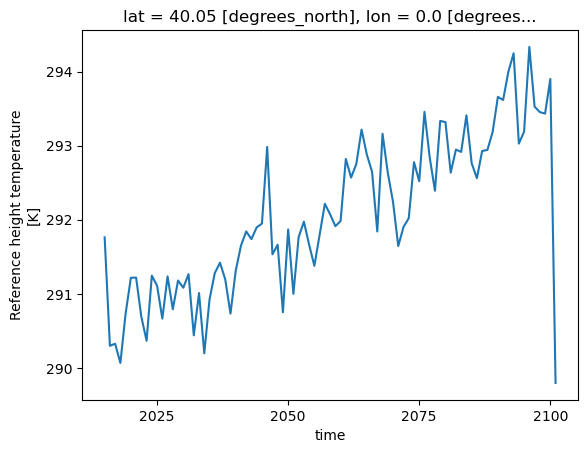

In [37]:
tb_mean.plot()

### Calculations over all grids

Remember, we can use basic calculations in Xarray. For example, let's convert the unit from Kelvin to degree Celsius:

In [26]:
# change the unit from Kelvin to degree Celsius 
tref_c = tref - 273.15
tref_c

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [27]:
%%time 

tref_c = tref_c.load()

CPU times: user 75.6 ms, sys: 546 ms, total: 621 ms
Wall time: 1.33 s


In [28]:
%%time

# Compute monthly anomaly

# -- 1. calculate monthly average
tref_grouped = tref.groupby('time.month')
tmean = tref_grouped.mean(dim='time')

#-- 2. calculate monthly anomaly
tos_anom = tref_grouped - tmean
tos_anom

CPU times: user 59 ms, sys: 540 µs, total: 59.6 ms
Wall time: 206 ms


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [29]:
%%time
computed_anom = tos_anom.load()
type(computed_anom)

CPU times: user 145 ms, sys: 204 ms, total: 349 ms
Wall time: 2.36 s


xarray.core.dataarray.DataArray

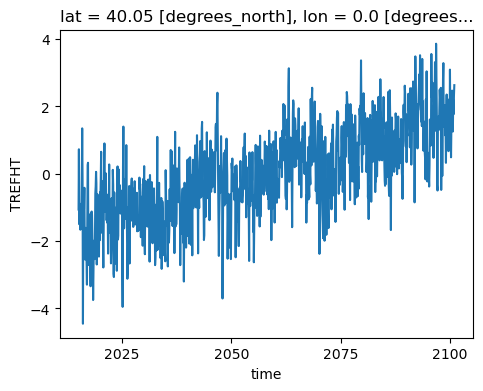

In [30]:
tos_anom.sel(lat=40.0150, lon=-105.2705, method='nearest').plot( size=4)

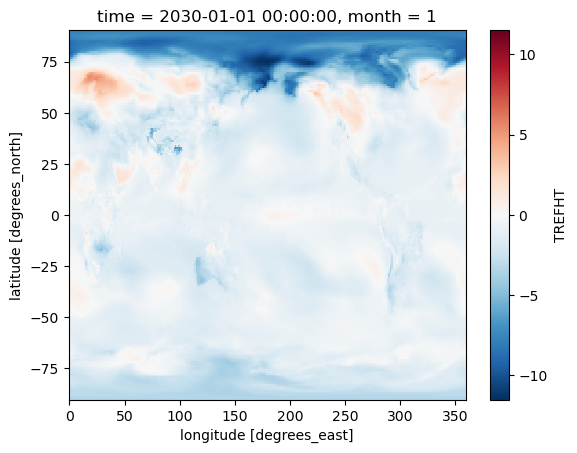

In [31]:
tos_anom.sel(time='2030-01-01').plot()

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> Using Xarray plotting functionality automatically triggers computations on the Dask Array, similar to `.compute()`.

</div>

We can do more complex calculations too:

In [47]:
rolling_mean = tref.rolling(time=5).mean()
rolling_mean  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(124, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

In [48]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032)>
dask.array<chunksize=(124,), meta=np.ndarray>
Coordinates:
    lat      float64 -71.15
    lon      float64 1.25
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

In [49]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
nan nan nan nan nan nan nan nan ... 273.4 273.4 273.4 273.4 273.4 273.4 273.4
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (3)

## Optimization and Debugging Dask 

### Scaling and Performance Report

Now, let's see what speedup we can get by manually scaling up our computation by 2x. This is not possible (*beyond a certain hardware limit*) on a `LocalCluster`, but is easy to do using `dask-jobqueue`!

In [33]:
# Scale the cluster to 4 workers
cluster.scale(4)
client.wait_for_workers(4)

In [34]:
# How does this look in PBS?
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
9368874.casper* negins   htc      STDIN       10374   1   1   16gb 24:00 R 02:08
9369492.casper* negins   htc      dask-wk23*  63091   1   1    4gb 00:30 R 00:06
9369493.casper* negins   htc      dask-wk23*  53109   1   1    4gb 00:30 R 00:06
9369522.casper* negins   htc      dask-wk23*    --    1   1    4gb 00:30 R   -- 
9369523.casper* negins   htc      dask-wk23*    --    1   1    4gb 00:30 R   -- 


One downside of scaling is that you end up with a worker pool that has different amounts of wallclock time remaining. The flow of your script across time is something to consider - if you need to spin up more workers after some collection of them has used significant walltime, it may make sense to first scale down your cluster to zero (or run `client.restart()`) and then instantiate the new workers.

Here, we will also demonstrate another type of performance monitoring provided by `dask.distributed` - the *performance report*. Using a context manager, we can profile the computational components in the task stream and store it as an HTML file for future analysis. It provides a hard copy analysis of the computation, though unfortunately it does not record worker memory usage.

In [35]:
# Let's try generating a "performance report" this time
from dask.distributed import performance_report

In [36]:
%%time
# Since metrics are captured live anyway, the overhead from the report is small
with performance_report(filename="dask-report.html"):
    result = computed.compute()

NameError: name 'computed' is not defined

Hopefully, we see a significant improvement in time-to-solution using 2x the workers.

Another improvement we can make to our computation is to reduce the size of the problem down as much as possible before doing meaningful work. Let's try rearranging our graph:

In [37]:
# Create our improved task graph
tref_mean_graph = tref.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"])

In [38]:
In this case, optimizations to the base operation can yield better speed improvements than doubling the dask worker count. Optimize your workflow first, if possible - then parallelize with Dask if still necessary.

Let's plot our results again to inspect for differences.

SyntaxError: unterminated string literal (detected at line 3) (2123432450.py, line 3)

#### Adaptive scaling

For interactive, exploratory work, *[adaptive scaling](https://docs.dask.org/en/stable/how-to/adaptive.html)* can be useful (also very useful on cloud platforms). This allows the cluster to dynamically scale up and down based on the (Dask) scheduler's estimation of resource needs. This capability is highly customizable, but one basic method would be to set bounds on the number of worker jobs that can be used:

```
cluster.adapt(minimum=0, maximum=12)
```

Another benefit of adaptive scaling is that you can use the worker `--lifetime` argument to tell Dask to cleanly end work on a worker and restart the PBS job. If you stagger the start of your workers, Dask will be able to shuffle tasks appropriately to produce a so-called *[infinite workload](https://jobqueue.dask.org/en/latest/advanced-tips-and-tricks.html#how-to-handle-job-queueing-system-walltime-killing-workers)*.

On busy systems, adaptive scaling can slow down bursty computations because of queue waits between scale-down and scale-up cycles.

### Optimization: Persisting data in worker memory

Sometimes you will need to compute multiple parameters on data from Dask objects. Using `.persist()` to store intermediate data in worker memory can save computational time if used appropriately. The raw data can be persisted too, of course, but watch out for exhausting worker memory.

Here we compare the time it takes - with and without persisting intermediate results - to compute our level-0 mean, a level-10 mean, and a mean across all model levels.

We will also introduce another diagnostic tool here, the `MemorySampler` context manager.

In [ ]:
from distributed.diagnostics import MemorySampler
ms = MemorySampler()

In [ ]:
%%time
# Without persistance
with ms.sample("Original"):
    r1 = ds.T.isel(lev = 0).sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).compute()
    r2 = ds.T.isel(lev = 10).sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).compute()
    ra = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lev","lat","lon"]).compute()

In [ ]:
%%time
# With persistance
with ms.sample("Persist"):
    T_means = ds.T.sel(lon = slice(235, 255), lat = slice(30,50)).mean(["lat","lon"]).persist()
    r1 = T_means.isel(lev = 0).compute()
    r2 = T_means.isel(lev = 10).compute()
    ra = T_means.mean("lev").compute()

In [ ]:
Without persisting the intermediate results, Dask will only store r1 and r2 in worker memory, and so the indexing operations must be done from scratch each time.

Let's look at the memory usage...

In [ ]:
ms.plot(align=True)

Because the intermediate results are required for the second calculation in the original case, we do not even use more memory. A clear win!

Of course, when persisting data it is extra important to clean up. Running `del` on your persisted client variable will clear those data from worker memory (*as long as they are not referenced by other variables*). The **progress** dashboard is a useful reminder that we have data persisted.

In [ ]:
del T_means

In [ ]:
# Close current workers
cluster.scale(0)

### Debugging workers case study: memory and spill-to-disk
In this section, we will demonstrate two common considerations when using Dask on HPC:
* Dask data spilling to disk
* Interacting with `dask.distributed` worker logs

For this case study, we will generate progressively larger Dask arrays that eventually trigger memory conditions. Dask workers handle data in different ways in the following memory regimes:

|Suggested Threshold|Case Study Value|Worker Behavior|
|-|-|-|
|0.6 (managed mem)|2.4 GB|Data is allocated on disk (spill)|
|0.7 (process mem)|2.8 GB|Data is allocated on disk (spill)|
|0.8|3.2 GB|New data allocation is paused|
|0.95|3.8 GB|Worker is killed to avoid OOM|

These thresholds can be set at cluster creation time or overridden by your Dask Distributed configuration file.

In [ ]:
import dask.array as da
from distributed.worker import logger

It is possible to write directly to worker logs (PBS job logs in our case) using the worker `logger` from Dask Distributed. Here, we define a function to call the logger on each worker, which we will run eagerly via `client.run`.

Keep an eye on the worker memory Dashboard panel as our for loop proceeds...

In [40]:
def log_message(chunk_size):
    logger.info("Current chunk size = {} MiB".format(chunk_size))

In [41]:
# Start up 4 new workers
cluster.scale(4)
client.wait_for_workers(4)

In [ ]:
for chunk_mib in [1600, 2400, 3200, 3900]:
    client.run(log_message, chunk_mib)
    chunk_size = chunk_mib / 8 * 1024 * 1024
    print("Mean of {} MiB random array = {:0.2f}".format(chunk_mib, da.random.random((chunk_size * 4), chunks=(chunk_size)).mean().compute()))

In [ ]:
# List the most recent 4 worker logs - these should be our logs
!ls -lrt dask-worker-logs | tail -n 4

We can open the log file in the Lab interface or a terminal and investigate the reason for the `KilledWorker` exception.

In [ ]:
# Let's look at the worker state in PBS after the failure
!qstat -u $USER

Notice how the workers retried the final computation a few times before giving up. This behavior occurs when using the `nanny`, which attempts to restore workers when they are killed for various exceptions. (*the nanny is an additional lightweight process that monitors the health of the worker and enables functionality like full cluster restart*)

Recall the aforementined memory thresholds - workers get killed by Dask before exceeding the absolute limit of a job (which if hit on certain systems, could kill the PBS job too). Because of this safety mechanism, our PBS jobs are still intact.

If you are running a long computation that, *if restarted*, could exhaust the worker job's walltime, you can disable the nanny functionality and make exceptions fatal.

In [ ]:
# Shut down our client (thus terminating workers)
client.shutdown()

### Supplementary Material: Advanced workflows and automatic parallelization using `apply_ufunc`
Most of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by Xarray to work with Dask, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function. `xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray. 

`xr.apply_ufunc()` give users capability to run custom-written functions such as parameter calculations in a parallel way. See the [Xarray tutorial material on apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/apply_ufunc.html) for more.

In the example below, we calculate the saturation vapor pressure by using `apply_ufunc()` to apply this function to our Dask Array chunk by chunk. 

In [ ]:
import numpy as np

def sat_p(t):
    """Calculate saturation vapor pressure using Clausius-Clapeyron equation"""
    return 0.611 * np.exp(17.67 * (t-273.15)*((t-29.65)**(-1)))

In [ ]:
es = xr.apply_ufunc(sat_p, tref, dask="parallelized", output_dtypes=[float])
es

In [ ]:
es.compute()

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? So far, we only run on one machine, what if we run an HPC cluster? We will go over this in the next tutorial.

### Dask + Xarray Good Practices

<div class="alert alert-success fade show" markdown="1">

<b>Summary of Dask + Xarray Good Practices</b> 


The good practices regarding Dask + Xarray is the same as the good practices for Dask only.

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* Avoid too many tasks since each task will introduce 1ms of overhead. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 

</div>



### Close you local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [ ]:
client.shutdown()

## Summary

In this notebook, we have learned about:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly..
* Customized workflows using `apply_ufunc`

## Resources and references

### Reference
*  [Dask Array Docs](https://docs.dask.org/en/stable/array.html)
*  [Dask Examples](https://examples.dask.org/)
*  [Dask Code](https://github.com/dask/dask/)
*  [Dask Blog](https://blog.dask.org/)
*  [Xarray Docs](https://xarray.pydata.org/)
*  [Xarray + Dask docs](https://docs.xarray.dev/en/stable/user-guide/dask.html), particularly the [optimization tips](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)
* [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
  

### Ask for help
*   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
*   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
*   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests